<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import pdb 
import glob
import copy
import math
import pickle
import csv

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, \
    StratifiedShuffleSplit, cross_val_score, StratifiedKFold, \
    GridSearchCV, RandomizedSearchCV

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, \
    ExtraTreesClassifier, VotingClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature

import missingno  # for visualizing missing data
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval, pyll
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

# Load line profiler
%load_ext line_profiler

# Adjust number of CPU cores to use
# n_jobs=2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [25]:
# Load true target variable for test set
y_test = joblib.load('data_processed/y_test.joblib')

In [9]:
! ls ./predictions_test

y_lr_hp
y_lr_hp.joblib
y_rf_hp
y_rf_hp.joblib
y_score_lr_hp.joblib
y_score_rf_hp.joblib
y_score_svm_lin_hp.joblib
y_svm_lin_hp
y_svm_lin_hp.joblib


In [7]:
# # Load individual models
# y_lr = joblib.load('predictions_test/y_lr_hp.joblib')
# y_rf = joblib.load('predictions_test/y_rf_hp.joblib')
# y_svm_lin = joblib.load('predictions_test/y_svm_lin_hp.joblib')

In [10]:
# Load predictions and combine them into a data frame
model_names = ['rf', 'lr', 'svm_lin']
y_preds = pd.DataFrame(
            {model_name: joblib.load(f'predictions_test/y_{model_name}_hp.joblib')
                for model_name in model_names})

In [18]:
# Compute average prediction
y_pred_mean = y_preds.mean(axis=1)

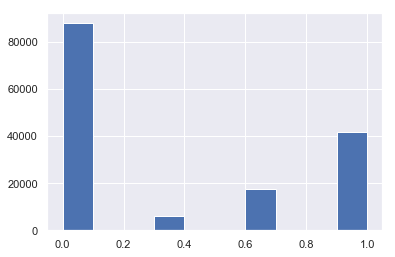

In [19]:
y_pred_mean.hist()

In [28]:
# AP (lower than individual models because we dont have enough threshholds)
average_precision_score(y_test, 
                        y_pred_mean)

0.3115252888567605

In [27]:
y_test.shape

(153499,)